# CE6003 Etivity 3
* Name : Martin Power
* ID    : 9939245

# Kalman Filter - Lab 7.2 Exercise

## Recap
We have seen how the kalman filter can be applied for object tracking.
It is recommended that you complete this exercise and then review lab7_2 once your understanding is improved. 

In this exercise we will used the kalman filter to predict the track of a cannonball. We will using the same kalman filter code block from the the previous lab. but in this case we will setup the problem and intialise the required matrices ourseleves before passing them to the Kalman filter. The problem is straightfoward to set up and uses the same equations of motion as shown in the videos and notes. A very useful reference that summarises the equations and  that will help you compelete this excercise is 
http://greg.czerniak.info/guides/kalman1/

The purpose of this exercise is to improve your understanding of how the Kalman Filter works. 



In [1]:
import os
import re
import io
import cv2
import time
import base64
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display



**Define Noisy Model to Generate Measurements**

A simple model of a cannonball is used to generate noisy measurements that we can supply to the kalman filter. This replaces the object centres from the Lab_7_2. The measurements include a noisy measurement of position and another measurment (with a different noise level) for velocity. 

[]

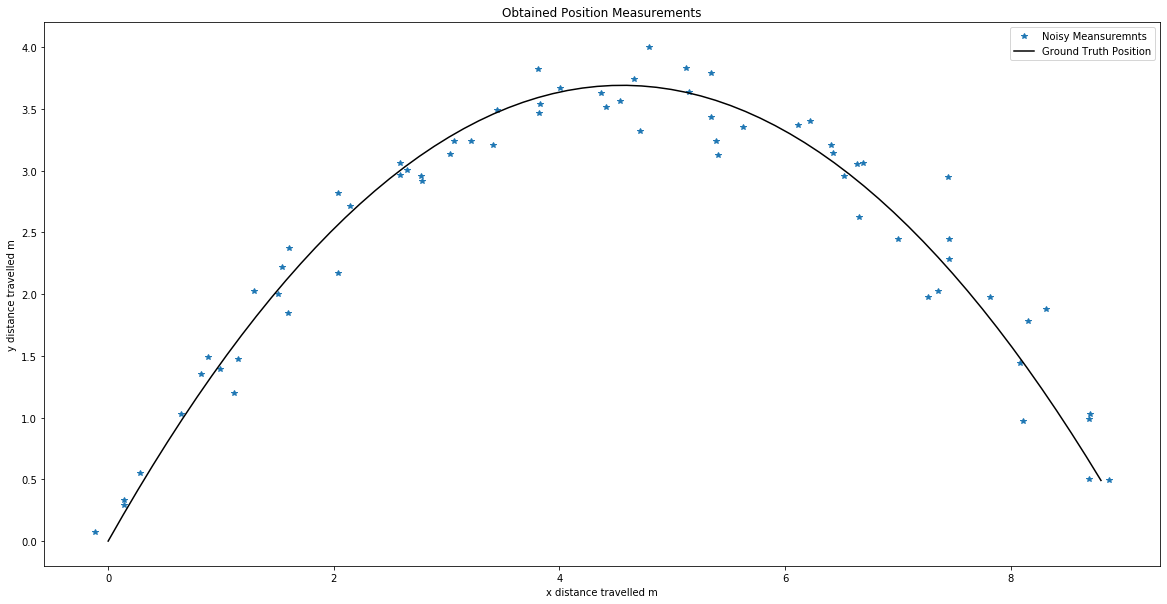

In [2]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.2 # Position noise
sigma2 = 0.1 # Velocity nois

def cannonball_model(v_o):
   v_ox = v_o*math.cos(theta) # x direction starting velocity.
   v_oy = v_o*math.sin(theta) # y direction starting velocity.
   x0 = 0
   y0 = 0
   xpos = np.array([])
   v_x = np.array([])
   ypos = np.array([])
   v_y = np.array([])
   xgt = np.array([])
   ygt = np.array([])

   for steps in range(t_steps):
      t = steps*dt
      # Calculate x equations of motion in x direction
      x = x0 + v_ox*t + np.random.normal(0,sigma)
      xpos=np.append(xpos,x)  
      # X Ground Truth Position
      xgt=np.append(xgt,(x0 + v_ox*t)) 
      v_xt = v_ox + np.random.normal(0,sigma2)

      v_x = np.append(v_x,v_xt)
      # Calculate equations of motion in y direction
      y = y0 + v_oy*t-0.5*g*(t**2) + np.random.normal(0,sigma)
      v_yt = v_oy-g*t+np.random.normal(0,sigma2)
      ypos=np.append(ypos,y)  
      v_y = np.append(v_y,v_yt)
      # Y Ground Truth Position
      ygt=np.append(ygt,(y0 + v_oy*t-0.5*g*(t**2)))

   return xpos,ypos,v_x,v_y,xgt,ygt
     
xpos,ypos,v_x,v_y,xgt,ygt=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(20,10))
plt.plot(xpos, ypos, '*', label="Noisy Meansuremnts")
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.legend(loc='best')
plt.plot()

**Kalman Model**

In [3]:
def kalman(x, P, z, R, u, Q, A, B, H):
    '''
    Dynamic Parameters
    x: state
    P: state uncertainty covariance
    measurement: measurement
    R: measurement noise

    return:
        updated and predicted new values for (x, P)
    '''

    # Update Step
    # Update x and P based on measurement m
    # distance between measured and current position-belief
    y = np.matrix(z).T - H * x
   
    S = H * P * H.T + R
    K = P * H.T * S.I
    x = x + K * y
    I = np.matrix(np.eye(A.shape[0]))
    P = (I - K*H)*P

    # Predict Step
    # Predict x and P based on motion
    x = A*x + B*u
    P = A*P*A.T + Q

    return x, P


**Initialise Matrices**
Take a look at the section "Multi Variable" example in http://greg.czerniak.info/guides/kalman1/ to see how to initialise the required matrices.
Note 1: The matrices are entered using the numpy matrix command which allows a string of values to be converted to a numpy array E.g.

    my_matrix=np.matrix('''
        1. 0. 0. 0.;
        0. 1. 0. 0.;
        0. 0. 1. 0.;
        0. 0. 0. 1. 
        ''')

Some matrices my need to initialised as a column, a row can be converted to a column with a Transpose operation with np.matrix

my_other_matrix = np.matrix('0.0 0.0 0. 0.').T

Note 2: you need to place values rather than symbolic expressions into the matrix

### Notes on Matrix Settings for initialise_matrices()

#### State Matrix _A_ and Control Matrix _B_

The State Matrix _A_ and Control Matrix _B_ were initialised as per the settings in the 'Multi-Variable Example' at http://greg.czerniak.info/guides/kalman1/


$$A = \begin{bmatrix} 1 & dt & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & dt \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

$$B = \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### State Vector _x_

The State Vector _x_ was set up to be initialised with an assumed initial position of (0,0) and an initial _x_ velocity of
`v_o`_cos(theta)_ and an initial _y_ velocity of `v_o`_sin(theta)_

$$x = \begin{bmatrix} x_{pos\_init} \\ x_{v\_init} \\ y_{pos\_init} \\ y_{v\_init} \end{bmatrix}$$

#### Control Vector _u_

The control vector was initialised as per the settings in the 'Multi-Variable Example' at http://greg.czerniak.info/guides/kalman1/ and model the effect of gravity on the y position and velocity

$$u = \begin{bmatrix} 0 \\ 0\\  (-\frac{1}{2})(g)(dt^2) \\ -(g)(dt) \end{bmatrix}$$

#### Prediction Covariance Matrix _P_

The _P_ matrix was initialised as per the recommendation in Lab_7_2 where a large value such as 100 is recommended

$$P = \begin{bmatrix} 100 & 0 & 0 & 0 \\ 0 & 100 & 0 & 0 \\ 0 & 0 & 100 & 0 \\ 0 & 0 & 0 & 100 \end{bmatrix}$$

#### Observation Matrix _H_

The _H_ matrix was initialised as an idenity matrix to link the state vectors to the measurements


$$H = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### Process Covariance Matrix _Q_

The _Q_ matrix was initialised as per the recommendation in Lab_7_2


$$Q = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

#### Measurement Covariance Matrix _R_

The _R_ matrix was the matrix that I most chopped and changed over the course of this lab. Initially, I was using the standard deviation of the position and velocity noise (`sigma` and `sigma2`) to populate the variance as follows:

$$R_{draft} = \begin{bmatrix} {sigma}^2 & 0 & 0 & 0 \\ 0 & {sigma2}^2 & 0 & 0 \\ 0 & 0 & {sigma}^2 & 0 \\ 0 & 0 & 0 & {sigma2}^2 \end{bmatrix}$$

This delivered good results provided I set the values in the Q matrix to near zero (otherwise the filter would be biased towards trusting the measurements more than the model and in this case we know the model is more accurate).

However, after a forum discussion with Victor Amaya and subsequently a question in the quiz where is said the variation is impossible to know, I backed away from this approach and instead started experimenting with different values in the _R_ matrix. If R settings were too low, I found the results followed the noise too much - in these instances the filter is giving too much importance to the measurements relative to the model. In the end I used I setting of 20 for all non-zero elements in the _R_ matrix.

I also considered using aysmetric values in the R Matrix, e.g. $$R_{draft} = \begin{bmatrix} 20 & 0 & 0 & 0 \\ 0 & 10 & 0 & 0 \\ 0 & 0 & 20 & 0 \\ 0 & 0 & 0 & 10 \end{bmatrix}$$ due to the fact that the position measurement is known to be noisier than the velocity measurement but in the end for the sake of simplicity I kept the values in the _R_ matrix to be all the same

$$R_{final} = \begin{bmatrix} 20 & 0 & 0 & 0 \\ 0 & 20 & 0 & 0 \\ 0 & 0 & 20 & 0 \\ 0 & 0 & 0 & 20 \end{bmatrix}$$

In [4]:
def initialise_matrices():
    # Using matrices from examples at http://greg.czerniak.info/guides/kalman1/

    # Initialise matrix state transition matrix A and state control matrix B
    # - State Transition Matrix A
    A = np.matrix([[1, dt,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  1, dt],
                   [0,  0,  0,  1]])

    # - Control Maxtrix B
    B = np.matrix([[0,  0,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  1,  0],
                   [0,  0,  0,  1]])


    # Initialise state vector x (x_pos, x_v, y_pos, y_v)  (Is a column)
    x_pos_init, y_pos_init = 0,0
    x_v_init, y_v_init     = v_o*math.cos(theta), v_o*math.sin(theta)
    x = np.matrix([[x_pos_init, x_v_init, y_pos_init, y_v_init]]).T


    # Initialise the control matrix u (Is a column)
    u = np.matrix([[0, 0, -0.5*g*dt*dt, -1.0*g*dt]]).T    


    # Initialise prediction covariance matrix P
    # Value of 100 recommended by Emdalo Notebook
    P_scale  = 100 
    P = np.matrix(np.eye(x.shape[0]))*P_scale

    # Setup observation matrix H (This links state vectors to measurement)
    H = np.matrix(np.eye(x.shape[0]))

    # Set process noise covariance matrix Q 
    # Value of 1 recommended by Emdalo Notebook
    Q_scale = 1.0
    Q = np.matrix(np.eye(x.shape[0]))*Q_scale

    # Set measurement noise covariance matrix R
    R_scale = 20.0
    R = np.matrix(np.eye(x.shape[0]))*R_scale

    return(A,B,x,u,P,Q,R,H) 


**Run Kalman Filter**
The measurements obtained from the simple cannonball model as supplied to the model along with initialised values from the previous cell.



68


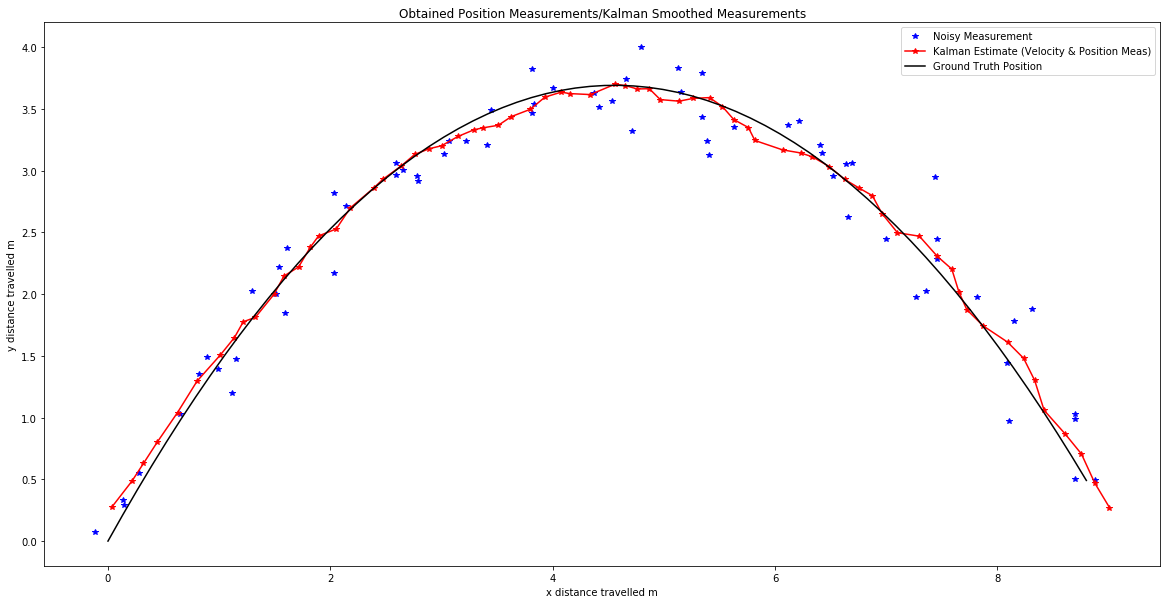

In [5]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


**Part 2: Demonstrate advantages of Kalman filter.**
A major advantage of the Kalman filter is the abilty to obtain the model state from a limited set of measurements. In this section we will determine the cannonball position from the noisy velocity measurements only.

In two code cells below replicate the code for initialise_matrices() and also that code to run the Kalman filter. In this case the code (Hint: matrix H and measurements vector z) are to be modified such that only the velocity measurements are applied to the model. As in the previous case the output should show the smooth track of the cannonball. 

### Notes on Matrix Settings for initialise_matrices2()

#### Observation Matrix _H_

Initially the _H_ matrix was initialised as an idenity matrix to link the state vectors to the measurements


$$H_{orig} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

However, for `initialise_matrices2()` only the noisy measurement velocities are being used and the noisy measurement 
positions are being ignored. As a results, the first and third row in the matrix is set to all zeroes in order to ignore
the position measurements.

$$H_{new} = \begin{bmatrix} 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$$

In [6]:
def initialise_matrices2():
    # Using matrices from examples at http://greg.czerniak.info/guides/kalman1/

    # Initialise matrix state transition matrix A and state control matrix B
    # - State Transition Matrix A
    A = np.matrix([[1, dt,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  1, dt],
                   [0,  0,  0,  1]])

    # - Control Maxtrix B
    B = np.matrix([[0,  0,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  1,  0],
                   [0,  0,  0,  1]])


    # Initialise state vector x (x_pos, x_v, y_pos, y_v)  (Is a column)
    x_pos_init, y_pos_init = 0,0
    x_v_init, y_v_init     = v_o*math.cos(theta), v_o*math.sin(theta)
    x = np.matrix([[x_pos_init, x_v_init, y_pos_init, y_v_init]]).T


    # Initialise the control matrix u (Is a column)
    u = np.matrix([[0, 0, -0.5*g*dt*dt, -1.0*g*dt]]).T    


    # Initialise prediction covariance matrix P
    # Value of 100 recommended by Emdalo Notebook
    P_scale  = 100 
    P = np.matrix(np.eye(x.shape[0]))*P_scale

    # Setup observation matrix H (This links state vectors to measurement)
    # Set the entries corresponding to position in the state vector to 0
    H = np.matrix([[0,  0,  0,  0],
                   [0,  1,  0,  0],
                   [0,  0,  0,  0],
                   [0,  0,  0,  1]])

    # Set process noise covariance matrix Q 
    # Value of 1 recommended by Emdalo Notebook
    Q_scale = 1.0
    Q = np.matrix(np.eye(x.shape[0]))*Q_scale

    # Set measurement noise covariance matrix R
    R_scale = 20.0
    R = np.matrix(np.eye(x.shape[0]))*R_scale

    return(A,B,x,u,P,Q,R,H) 


68


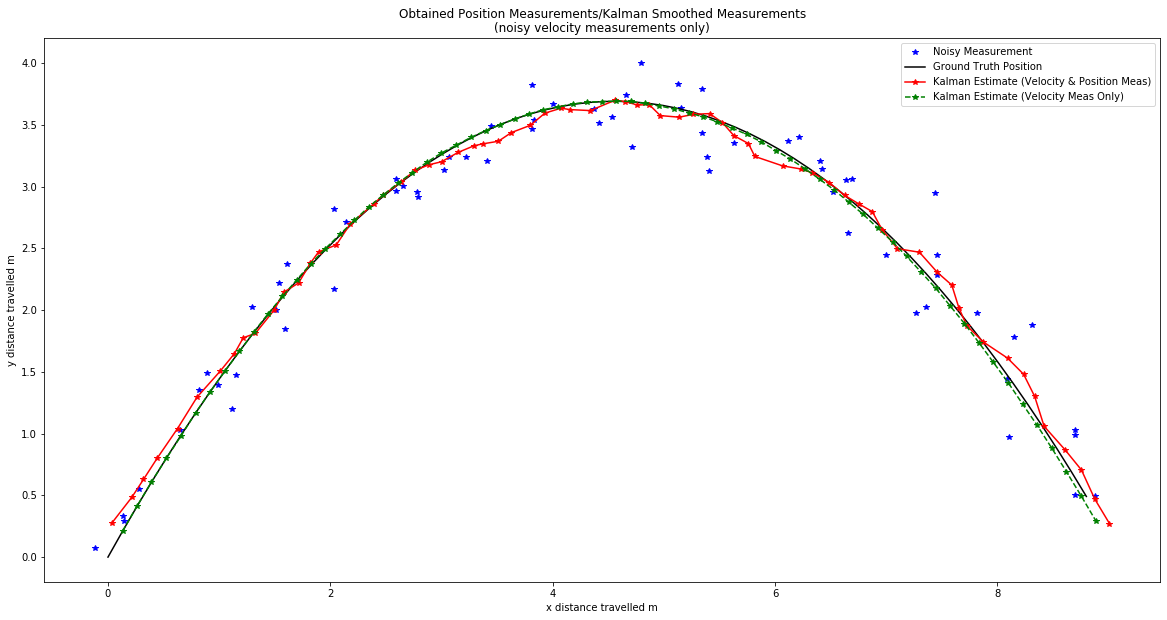

In [7]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)')
plt.legend()
plt.show()


## Analysis on Results
* The black line shows the ground truth trajectory with the noisy position measurements as blue stars.
* The Kalman filter that uses both position and velocity measurements is the red line and it moves around a bit away from
  the ground trush and you can see that it follows the noise a little bit. If I used values <10 in the R matrix then it 
  followed the noise quite a bit. Using a value of 20 gave the above result. Very large values of R (e.g. >200) produce
  very smooth results but in these instances the filter is really ignoring the measurements and just using the model
* The Kalmam filter that uses only the velocity measurements is much smoother. In part this is because the velocity
  measurements are not as noisy and also possibly because there are fewer variables to correlate between.

# Additional Model with Increased Position Noise (Sigma = 0.8)

[]

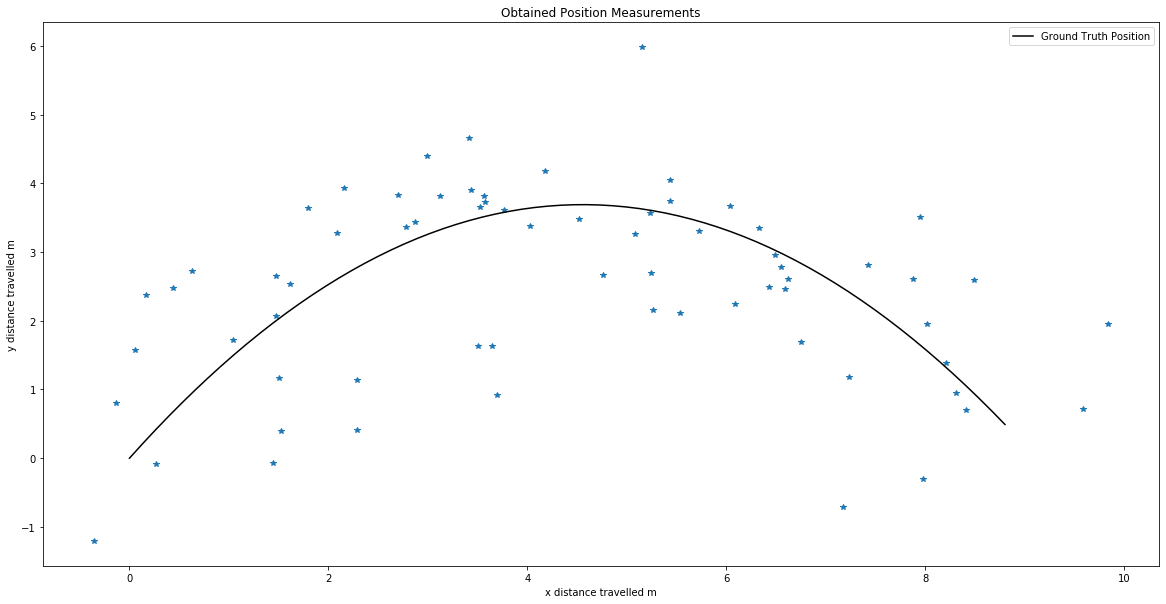

In [8]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.8 # Position noise increased from 0.2 to 0.8
sigma2 = 0.1 # Velocity nois
     
xpos,ypos,v_x,v_y,xgt,ygt=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(20,10))
plt.plot(xpos, ypos, '*')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.legend(loc='best')
plt.plot()

## Use Velocity  and Position Measurements

68


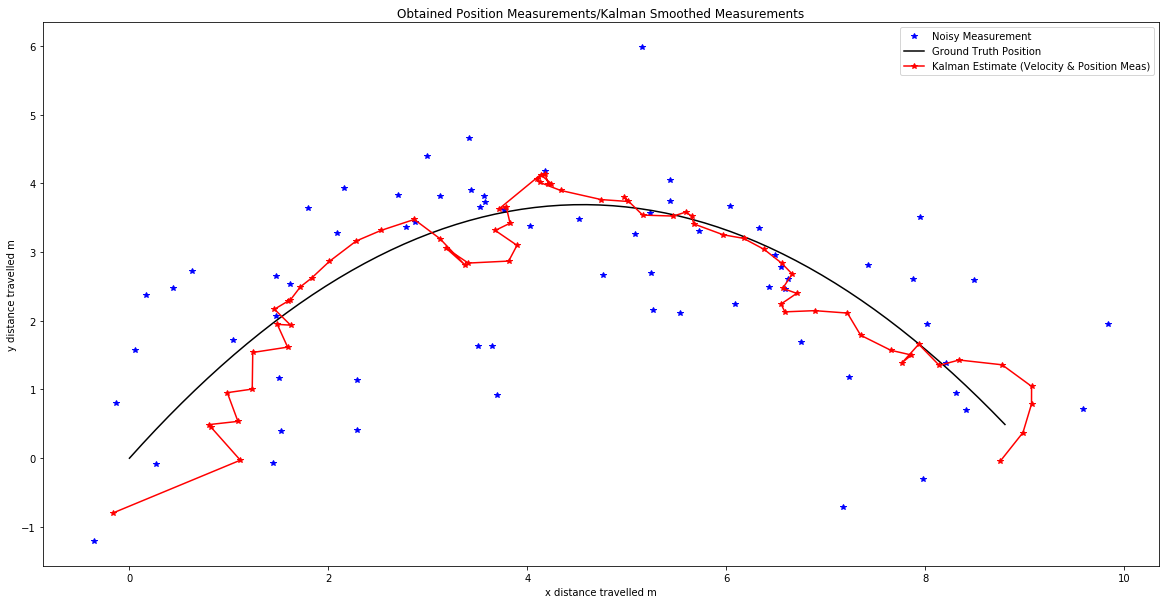

In [9]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


## Use Velocity Measurements Only

68


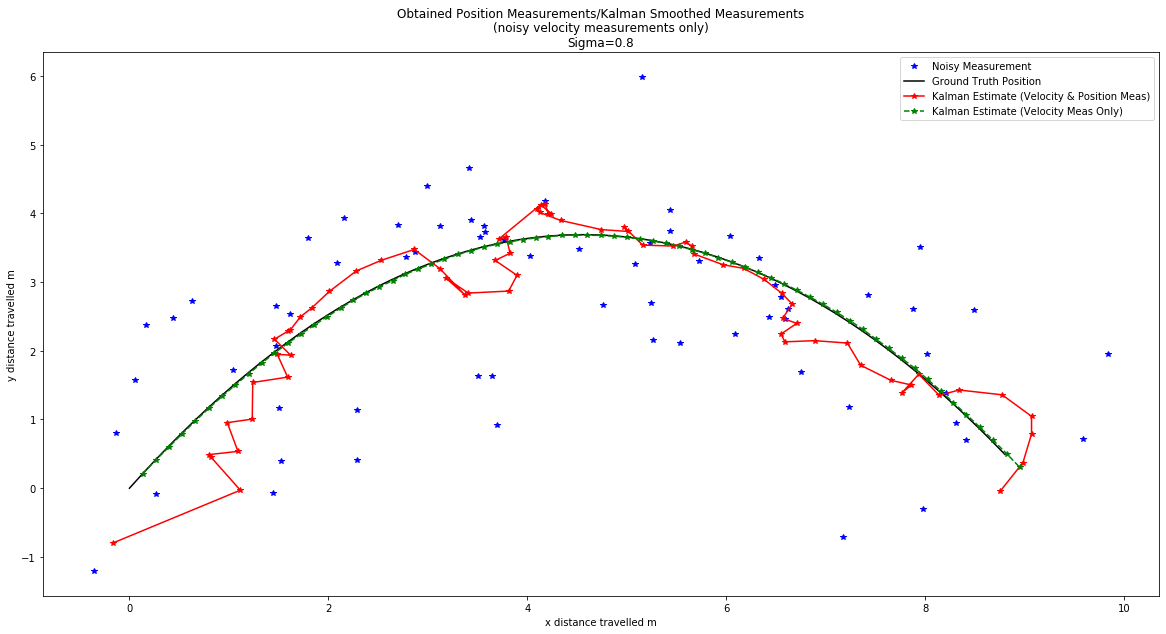

In [10]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)\nSigma=0.8')
plt.legend()
plt.show()


## Additional Model with Increased Position Noise (Sigma = 0.8)
* The standard deviation on the position measurements has been increased from 0.2 to 0.8 and this can be seen
  in the spread of the blue stars away from the black ground truth line.
* The red line from the filter with both position and velocity measurements moves aboout quite a bit due to the additional noise. 
  Adjusting the R matrix values to account for the higher variance in the position measurements relative to the velocity 
  measurements may help improve this
* The green line from the filter with just velocity measurements tracks the ground truth very well as the noise has not been increased
  and the noise that it present is filtered away

# Additional Model with Increased Velocity Noise (Sigma2 = 0.8)

[]

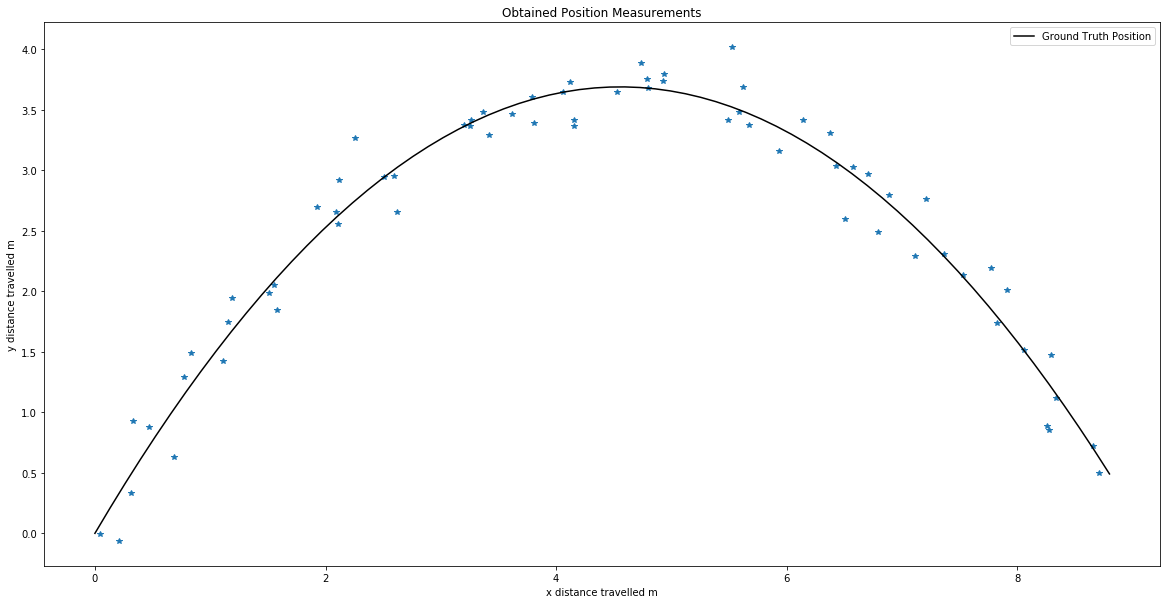

In [11]:
# Simple cannon ball model that generates a series of noise measurements at each time step.

dt  = 0.025 # Time step.
t_end = 1.72   # Final time
t_steps = int(t_end/dt) #Number of time steps required
v_o  = 10 # Intial velocity m/s
theta = 45 # Launch angle
g = 9.81   #Graviational acceleration m/s2
sigma = 0.2 # Position noise
sigma2 = 0.8 # Velocity noise increased from 0.1 to 0.8
   
xpos,ypos,v_x,v_y,xgt,ygt=cannonball_model(v_o)

# Stitch these model outputs into one matrix of measurements z
z_all= np.concatenate((xpos,v_x,ypos,v_y)).reshape(4,len(xpos))

# Plot the trajectory with noise.
plt.figure(figsize=(20,10))
plt.plot(xpos, ypos, '*')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements')
plt.legend()
plt.plot()

## Use Velocity  and Position Measurements

68


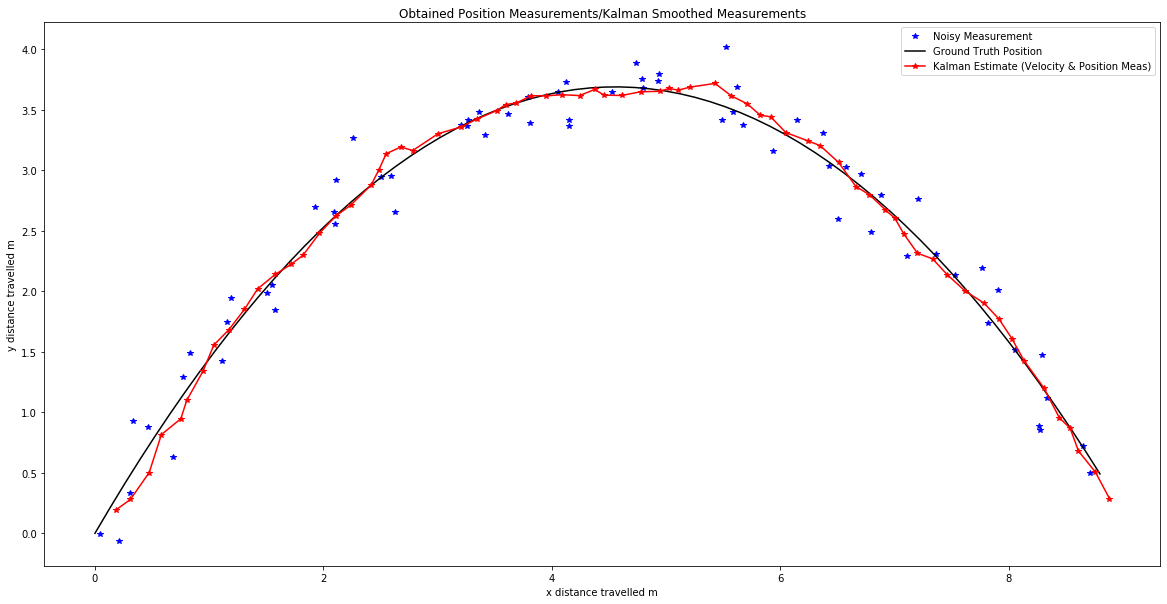

In [12]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices()

# Create arrays to store kalman estimates
xpos_est = np.array([])
v_x_est = np.array([])
ypos_est = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   z = z_all[:,i]

   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est=np.append(xpos_est,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est=np.append(ypos_est,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements')
plt.legend()
plt.show()


## Use Velocity Measurements Only

68


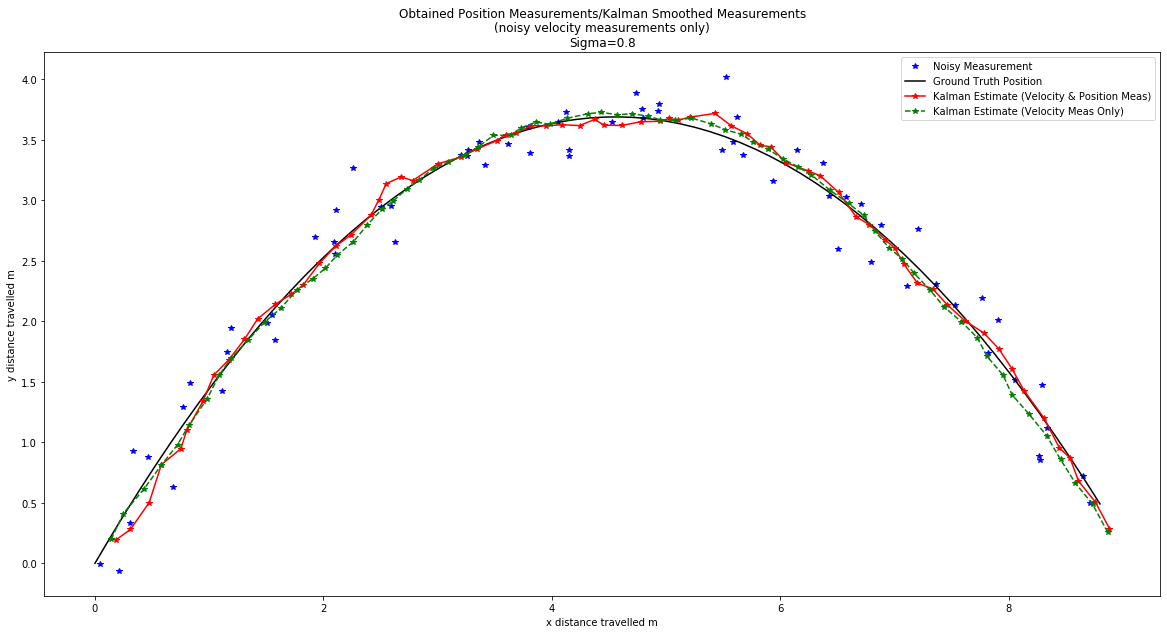

In [13]:
# Reinitialise the matrices/varaibles
A,B,x,u,P,Q,R,H = initialise_matrices2()

# Create arrays to store kalman estimates
xpos_est2 = np.array([])
v_x_est = np.array([])
ypos_est2 = np.array([])
v_y_est = np.array([])

print(t_steps)
# Get Kalman Updates.
for i in range(t_steps):
   # Input meaurements taken from model sequentially into z vector
   # Set the entries corresponding to position in the z to 0
   z_tmp = z_all[:,i]
   z = np.matrix([0, z_tmp[1], 0, z_tmp[3]])
   x, P = kalman(x, P, z, R, u, Q, A, B, H)

   xpos_est2=np.append(xpos_est2,x[0])
   v_x_est=np.append(v_x_est,x[1])
   ypos_est2=np.append(ypos_est2,x[2])
   v_y_est=np.append(v_y_est,x[3])


plt.figure(figsize=(20,10))
# Plot earlier noisy estimate
plt.plot(xpos, ypos,'b*', label='Noisy Measurement')
plt.plot(xgt, ygt, 'k-', label="Ground Truth Position")
# Plot kalman smoothed estimate
plt.plot(xpos_est, ypos_est,'r*-', label='Kalman Estimate (Velocity & Position Meas)')
# Plot kalman smoothed estimate ((Velocity Measurements Only))
plt.plot(xpos_est2, ypos_est2,'g*--', label='Kalman Estimate (Velocity Meas Only)')
plt.xlabel('x distance travelled m')
plt.ylabel('y distance travelled m')
plt.title('Obtained Position Measurements/Kalman Smoothed Measurements\n(noisy velocity measurements only)\nSigma=0.8')
plt.legend()
plt.show()


## Additional Model with Increased Velocity Noise (Sigma2 = 0.8)
* The standard deviation on the velocity measurements has been increased from 0.1 to 0.8. As the velocity is not plotted, this
  increase is not observable in the graphs.
* The red line from the filter with both position and velocity measurements follows the ground truth reasonably well although
  tends to follow the noise when encountering the position points that are the furthest outlier.
* The green line from the filter with just velocity measurements moves around much more than previous versions due to the additional
  noise on the velocity measurements and this can be seen as slight overshoots and undershoots on the ground truth. It is still a 
  more smooth trajectory than the model with position measurements also included.